In [1]:
from ast import literal_eval
import matplotlib.pyplot as plt

with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)
params["timeshift"] = 0.
params["em_syserr"] = 0.3
params["sys_err"] = 0.3

# NMMA

In [2]:
import os
import types

import numpy as np

import bilby
from bilby.gw.prior import Uniform, Constraint, PriorDict

from nmma.em.io import loadEvent
from nmma.em.model import GRBLightCurveModel
from nmma.em.em_likelihood import EMTransientLikelihood
from nmma.joint.conversion import distance_modulus_nmma

from fiesta.inference.lightcurve_model import AfterglowFlux

########
# DATA #
########

nmma_data = loadEvent("./data/injection_afterglowpy_gaussian.dat")
trigger_time = 58849
FILTERS = ["besselli"] # list(nmma_data.keys())

#########
# MODEL #
#########

def nmma_conversion_function(sample):
    converted_sample = sample
    converted_sample["thetaWing"] = converted_sample["thetaCore"] * converted_sample["alphaWing"]
    converted_sample["epsilon_tot"] = 10**(converted_sample["log10_epsilon_B"]) + 10**(converted_sample["log10_epsilon_e"]) 
    return converted_sample, ["epsilon_tot", "thetaWing"]

model = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = FILTERS)

def generate_lightcurve(self, sample_times, parameters):
    t, mag = self.predict(parameters)
    
    d_lum = parameters.get("luminosity_distance", 1e-5) ## default 10pc = 1e-5 Mpc
    distance_modulus = distance_modulus_nmma(d_lum)
    
    for key in mag.keys():
        mag[key] = np.interp(sample_times, t, mag[key] - distance_modulus)

    return np.ones(len(sample_times)), mag

model.generate_lightcurve = types.MethodType(generate_lightcurve, model)

#########
# PRIOR #
#########

inclination_EM = Uniform(minimum=0.0, maximum=np.pi/2, name='inclination_EM')
log10_E0 = Uniform(minimum=47.0, maximum=57.0, name='log10_E0')
alphaWing = Uniform(minimum=0.2, maximum=3.4, name = 'alphaWing')
thetaCore = Uniform(minimum=0.01, maximum=np.pi/5, name='thetaCore')
log10_n0 = Uniform(minimum=-6.0, maximum=2.0, name='log10_n0')
p = Uniform(minimum=2.01, maximum=3.0, name='p')
log10_epsilon_e = Uniform(minimum=-4.0, maximum=0.0, name='log10_epsilon_e')
log10_epsilon_B = Uniform(minimum=-8.0, maximum=0.0, name='log10_epsilon_B')
thetaWing = Constraint(minimum=0, maximum=np.pi/2, name='thetaWing')
epsilon_tot = Constraint(minimum=0, maximum=1, name='epsilon_tot')
em_syserr = Uniform(minimum=0.3, maximum=1, name='em_syserr')

luminosity_distance = 40.0
redshift = 0.
timeshift = 0.

prior_dict = dict(inclination_EM = inclination_EM, 
              log10_E0 = log10_E0, 
              thetaCore = thetaCore, 
              alphaWing = alphaWing,
              log10_n0 = log10_n0, 
              p = p, 
              log10_epsilon_e = log10_epsilon_e, 
              log10_epsilon_B = log10_epsilon_B,
              luminosity_distance = luminosity_distance, 
              redshift = redshift,
              timeshift = timeshift,
              thetaWing = thetaWing,
              epsilon_tot = epsilon_tot,
              em_syserr = em_syserr,
)

nmma_priors = PriorDict(dictionary = prior_dict, conversion_function = lambda x: nmma_conversion_function(x)[0])



likelihood_kwargs = dict(
    light_curve_model=model,
    light_curve_data=nmma_data,
    filters = FILTERS,
    trigger_time = trigger_time,
    tmin=1e-2,
    tmax = 200.0,
    priors=nmma_priors)

nmma_likelihood = EMTransientLikelihood(**likelihood_kwargs)

Install keras if you want to use machine-learning surrogates for the EOS or KN models.
Install afterglowpy if you want to simulate afterglows.
Install wrapt_timeout_decorator if you want timeout simulations.


/home/enlil/hkoehn/miniconda3/envs/nmma_x_fiesta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
11:19 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
11:19 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
11:19 fiesta INFO    : 	 log10_E0: (47, 57)
11:19 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
11:19 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
11:19 fiesta INFO    : 	 log10_n0: (-6, 2)
11:19 fiesta INFO    : 	 p: (2.01, 3)
11:19 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
11:19 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
11:19 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['besselli'].
11:19 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/w

# fiesta

In [3]:
import os

import numpy as np
import jax
import jax.numpy as jnp

from fiesta.inference.prior import Uniform, Constraint, LogUniform
from fiesta.inference.prior_dict import ConstrainedPrior
from fiesta.inference.likelihood import EMLikelihood
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.utils import load_event_data




########
# DATA #
########

fiesta_data = load_event_data("./data/injection_afterglowpy_gaussian.dat")
trigger_time = 58849
FILTERS = ["besselli"] #fiesta_data.keys()

#########
# MODEL #
#########

model = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = FILTERS)


#########
# PRIOR #
#########

inclination_EM = Uniform(xmin=0.0, xmax=np.pi/2, naming=['inclination_EM'])
log10_E0 = Uniform(xmin=47.0, xmax=57.0, naming=['log10_E0'])
thetaCore = Uniform(xmin=0.01, xmax=np.pi/5, naming=['thetaCore'])
alphaWing = Uniform(xmin = 0.2, xmax = 3.5, naming= ["alphaWing"])
thetaWing = Constraint(xmin = 0, xmax = np.pi/2, naming = ["thetaWing"])
log10_n0 = Uniform(xmin=-6.0, xmax=2.0, naming=['log10_n0'])
p = Uniform(xmin=2.01, xmax=3.0, naming=['p'])
log10_epsilon_e = Uniform(xmin=-4.0, xmax=0.0, naming=['log10_epsilon_e'])
log10_epsilon_B = Uniform(xmin=-8.0, xmax=0.0, naming=['log10_epsilon_B'])
epsilon_tot = Constraint(xmin = 0., xmax = 1., naming=["epsilon_tot"])
sys_err = Uniform(xmin=0.3, xmax=1.0, naming=["sys_err"])

def fiesta_conversion_function(sample):
    converted_sample = sample
    converted_sample["thetaWing"] = converted_sample["thetaCore"] * converted_sample["alphaWing"]
    converted_sample["epsilon_tot"] = 10**(converted_sample["log10_epsilon_B"]) + 10**(converted_sample["log10_epsilon_e"]) 
    return converted_sample

prior_list = [inclination_EM, 
              log10_E0, 
              thetaCore,
              alphaWing,
              log10_n0, 
              p, 
              log10_epsilon_e, 
              log10_epsilon_B,
              thetaWing,
              sys_err,
              epsilon_tot]

fiesta_prior = ConstrainedPrior(prior_list, fiesta_conversion_function)

################
# LIKELIHOOD & #
# SAMPLING     #
################
  
  
detection_limit = None
fiesta_likelihood = EMLikelihood(model,
                          fiesta_data,
                          FILTERS,
                          tmin=1e-2, 
                          tmax = 200.0,
                          trigger_time=trigger_time,
                          detection_limit = detection_limit,
                          fixed_params={"luminosity_distance": 40.0, "redshift": 0.0}
                          )

fiesta_likelihood._setup_sys_uncertainty("free")

11:19 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
11:19 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
11:19 fiesta INFO    : 	 log10_E0: (47, 57)
11:19 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
11:19 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
11:19 fiesta INFO    : 	 log10_n0: (-6, 2)
11:19 fiesta INFO    : 	 p: (2.01, 3)
11:19 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
11:19 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
11:19 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['besselli'].
11:19 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/afgpy_gaussian_CVAE/model.
11:19 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
11:19 fiesta INFO    : No detection limit is given. Putting it to infinity.
11:19 fiesta INFO    : Converting error budget to dictiona

In [4]:
fiesta_likelihood.evaluate(params)

{'besselli': Array([11.313233, 11.466646, 12.370779, 13.70109 , 15.911467, 16.197222,
       17.173655, 17.70843 , 17.818977, 18.320227, 19.641937, 19.95587 ,
       21.114216, 21.889973, 24.448864, 25.852394, 26.452423, 26.55966 ],      dtype=float32)}


Array(3.3693666, dtype=float32)

In [8]:
nmma_likelihood.parameters = params
nmma_likelihood.log_likelihood()

-4.291248952936134

In [ ]:
_, model_mags = nmma_likelihood.sub_model.light_curve_model.generate_lightcurve(
            nmma_likelihood.sub_model.sample_times, params
        )

model_time, model_mag = nmma_likelihood.sub_model.update_lightcurve_reference(_, model_mags)["besselli"]

from nmma.em.utils import autocomplete_data
est_mag = autocomplete_data(nmma_data["besselli"][:,0]- params["trigger_time"], model_time, model_mag)

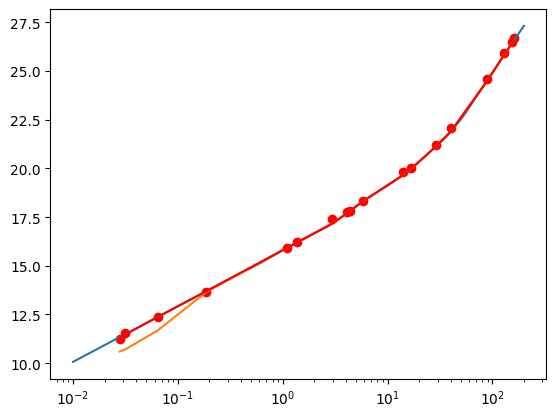

In [37]:
plt.plot(model_time, model_mag)
plt.plot(nmma_data["besselli"][:,0]- params["trigger_time"], est_mag)

plt.plot(nmma_data["besselli"][:,0]- params["trigger_time"], np.array([11.313233, 11.466646, 12.370779, 13.70109 , 15.911467, 16.197222,
       17.173655, 17.70843 , 17.818977, 18.320227, 19.641937, 19.95587 ,
       21.114216, 21.889973, 24.448864, 25.852394, 26.452423, 26.55966 ]), color="red")

plt.scatter(fiesta_data["besselli"][:,0] - params["trigger_time"], fiesta_data["besselli"][:,1], color="red")

plt.xscale("log")

In [ ]:
def autocomplete_data(interp_points, ref_points, ref_data, extrapolate='linear', ref_value=np.nan):
    """
    Interpolates and extrapolates reference data to a 1-D array of arguments. This can be wide off!
    This basically extends np.interp to ignore nans and provide simple extrapolations. 
    """
    
    ii = np.where(np.isfinite(ref_data))[0]
    if len(ii) < 2:
        return np.full_like(interp_points, ref_value)
    
    fin_ref= np.asarray(ref_points)[ii]
    fin_data=np.asarray(ref_data)[ii]
    interp_points=np.atleast_1d(interp_points)

    if isinstance(extrapolate, (float , int)):
        interp_data = np.interp(interp_points, fin_ref, fin_data,
                                 left=extrapolate, right=extrapolate)
      
    elif isinstance(extrapolate, str):
        if extrapolate=='spline':
            spline = interp.UnivariateSpline(fin_ref, fin_data, s=ref_value)
            interp_data = spline(interp_points)

        if extrapolate=='linear':
            interp_data = np.interp(interp_points, fin_ref, fin_data)
            x0, x1, xm, xn = fin_ref[ [0,1,-2,-1]]
            y0, y1, ym, yn = fin_data[[0,1,-2,-1]]
            lower_extrap_args= np.argwhere(interp_points<x0)
            interp_data[lower_extrap_args] = y0 + (y1-y0)/(x1-x0)*(interp_points[lower_extrap_args]-x0)
            upper_extrap_args = np.argwhere(interp_points>xn)
            interp_data[upper_extrap_args] = yn + (yn-ym)/(xn-xm)*(interp_points[upper_extrap_args]-xn)
        ## TODO Allow more sophisticated treatment of extrapolation
    
    else:
        interp_data = np.interp(interp_points, fin_ref, fin_data,
                                 left=extrapolate[0], right=extrapolate[-1])   
    return interp_data

In [74]:
fiesta_t, fiesta_mag = model.predict(params)
est_mag2 = np.interp(nmma_data["besselli"][:,0]- params["trigger_time"], fiesta_t, fiesta_mag["besselli"]) #autocomplete_data(nmma_data["besselli"][:,0]- params["trigger_time"], model_time, model_mag)

In [62]:
model_time

array([1.0000e-02, 1.1000e-01, 2.1000e-01, ..., 1.9971e+02, 1.9981e+02,
       1.9991e+02])

In [61]:
nmma_data["besselli"][:,0]- params["trigger_time"]

array([2.78510301e-02, 3.14668287e-02, 6.42917477e-02, 1.87551389e-01,
       1.08925013e+00, 1.37281257e+00, 2.98243431e+00, 4.12275696e+00,
       4.38751632e+00, 5.85827389e+00, 1.39130926e+01, 1.65666032e+01,
       2.87785843e+01, 4.00604523e+01, 8.78875412e+01, 1.30474029e+02,
       1.54771801e+02, 1.59714297e+02])

(0.01, 0.2)

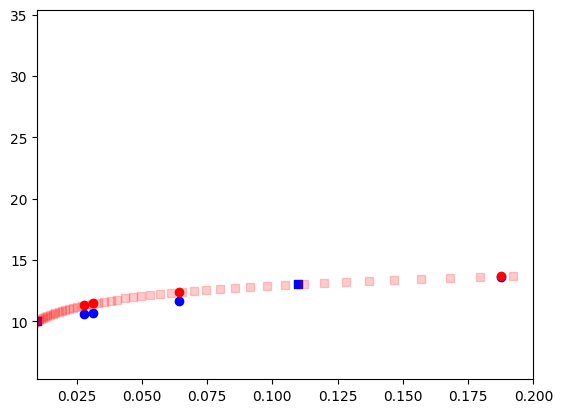

In [81]:
plt.scatter(nmma_data["besselli"][:,0]- params["trigger_time"], est_mag, color="blue")
plt.scatter(nmma_data["besselli"][:,0]- params["trigger_time"], est_mag2, color="red")


plt.scatter(model_time, model_mag, color="blue", marker="s")
plt.scatter(fiesta_t, fiesta_mag["besselli"], color="red", marker="s", alpha=0.2)

plt.xlim(1e-2, 2e-1)